In [1]:
# %env PYTORCH_ENABLE_MPS_FALLBACK=1
%load_ext autoreload
%autoreload

from bins import Bins
from utils import calcOneChi2, HistMaker_1d, diffHist
from ROOT import TFile, TH1, TH3F, TF2, TCanvas, TStyle, gStyle, Form, Fit, TLegend
import scipy.optimize as opt
import math
import calendar, os
from time import time, gmtime

Welcome to JupyROOT 6.28/04


In [2]:
read_saved = True
range_used = range(0,12)

if read_saved:
    DIR_NAME = "results_sameevt_nu15_noise1em1_1d"
else:
    current_GMT =   gmtime()
    time_stamp = calendar.timegm(current_GMT)
    DIR_NAME = f'results_{time_stamp}'
    os.mkdir(DIR_NAME)

In [3]:
bins = Bins.readFrom("ranges.yml")
#histMakerData_np = HistMaker_1d("apr12_diele_088_090_ag123ag_2500A_accepted_np_mix_hc_sample_2.dat", "_data", bins)
histMakerData_np = HistMaker_1d("apr12_diele_088_090_ag123ag_2500A_accepted_np_2.dat", "_data_np", bins)
histsData_np = histMakerData_np.makeHists()
histMakerData_pp = HistMaker_1d("apr12_diele_088_090_ag123ag_2500A_accepted_pp_2.dat", "_data_pp", bins)
histsData_pp = histMakerData_pp.makeHists()
histMakerData_nn = HistMaker_1d("apr12_diele_088_090_ag123ag_2500A_accepted_nn_2.dat", "_data_nn", bins)
histsData_nn = histMakerData_nn.makeHists()
histMakerMC_rho = HistMaker_1d("mar19_diele_inmedium_heli0cm_np.dat", "_MC_rho", bins)
histMakerMC_pi0 = HistMaker_1d("mar19_diele_pi0_heli0cm_np.dat", "_MC_pi0", bins)
def getHistMakerMC(HIST_INDEX):
    return histMakerMC_pi0 if HIST_INDEX < 3 else histMakerMC_rho
   # return histMakerMC_rho


iter 0
#1 [[<cppyy.gbl.TH1F object at 0x1576a4c10>, <cppyy.gbl.TH1F object at 0x1576a5000>, <cppyy.gbl.TH1F object at 0x1576a53f0>, <cppyy.gbl.TH1F object at 0x1576a57e0>, <cppyy.gbl.TH1F object at 0x1576a5bd0>, <cppyy.gbl.TH1F object at 0x1576a5fc0>, <cppyy.gbl.TH1F object at 0x1576a63b0>, <cppyy.gbl.TH1F object at 0x1576a67a0>, <cppyy.gbl.TH1F object at 0x1576a6b90>, <cppyy.gbl.TH1F object at 0x1576a6f80>, <cppyy.gbl.TH1F object at 0x1576a7370>, <cppyy.gbl.TH1F object at 0x1576a7760>], [<cppyy.gbl.TH1F object at 0x1576a7b50>, <cppyy.gbl.TH1F object at 0x1576a8330>], [<cppyy.gbl.TH1F object at 0x1576a7f40>, <cppyy.gbl.TH1F object at 0x1576a8720>]]
#2 [[<cppyy.gbl.TH1F object at 0x1608d0880>, <cppyy.gbl.TH1F object at 0x1608d0c70>, <cppyy.gbl.TH1F object at 0x1608d1060>, <cppyy.gbl.TH1F object at 0x1608d1450>, <cppyy.gbl.TH1F object at 0x1608d1840>, <cppyy.gbl.TH1F object at 0x1608d1c30>, <cppyy.gbl.TH1F object at 0x1608d2020>, <cppyy.gbl.TH1F object at 0x1608d2410>, <cppyy.gbl.TH1F ob

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/base_hists_pi0_MC.gif has been created


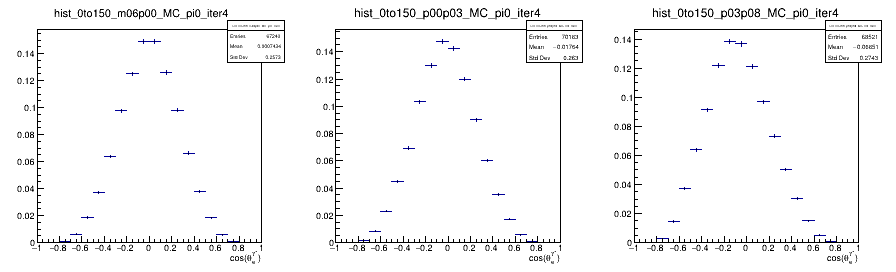

In [4]:
base_hists_pi0 = histMakerMC_pi0.builder.base_hists
can3 = TCanvas("can3","can3",900,300)
can3.Divide(3,1)
can3.Draw()
for i, hist in enumerate(base_hists_pi0[0]):
    if i < 3:
        can3.cd(i+1)
        if not isinstance(hist, list):
            hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
            hist.Draw()
        else:
            print(hist)
can3.SaveAs(f"{DIR_NAME}/base_hists_pi0_MC.gif")

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/base_hists_rho_MC.gif has been created


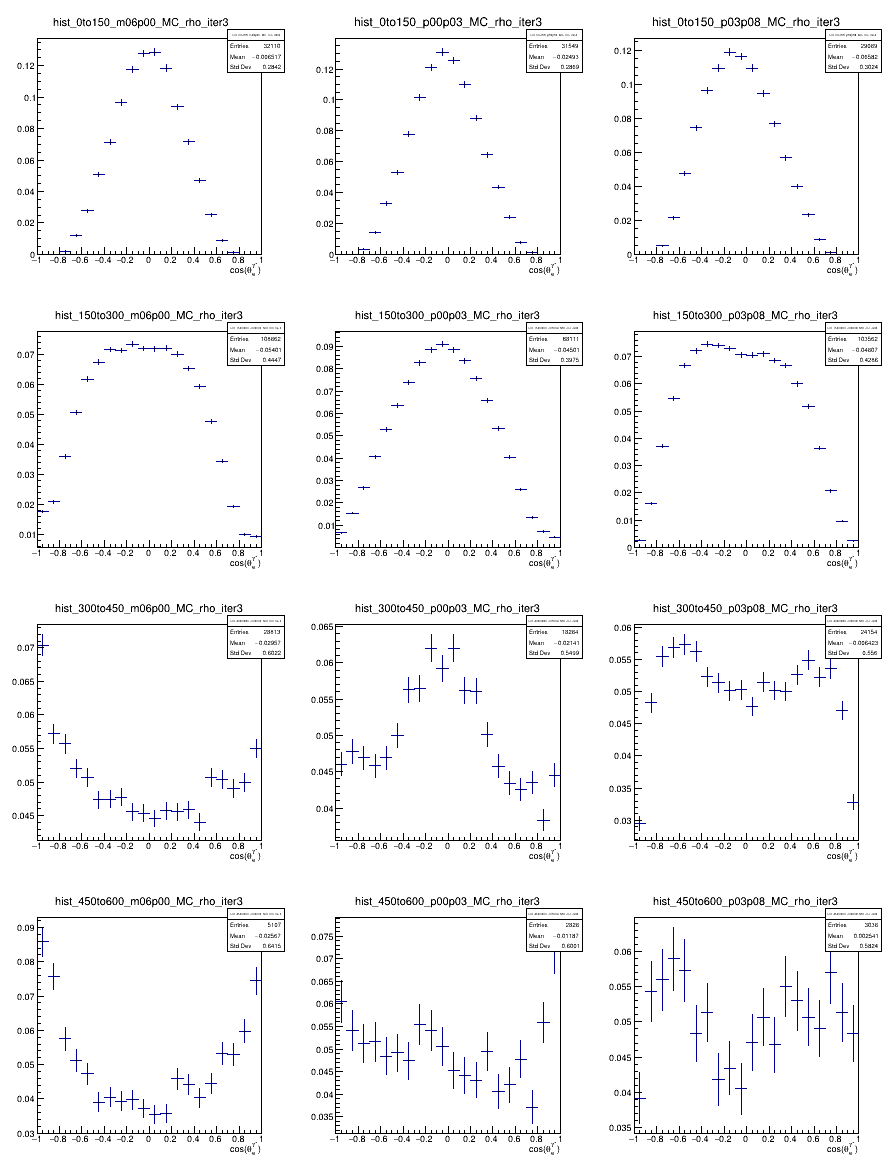

In [5]:
base_hists_rho = histMakerMC_rho.builder.base_hists
can5 = TCanvas("can5","can5",900,1200)
can5.Divide(3,4)
can5.Draw()
for i, hist in enumerate(base_hists_rho[0]):
    can5.cd(i+1)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        hist.Draw()
    else:
        print(hist)
can5.SaveAs(f'{DIR_NAME}/base_hists_rho_MC.gif')


Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/histsData_np.gif has been created


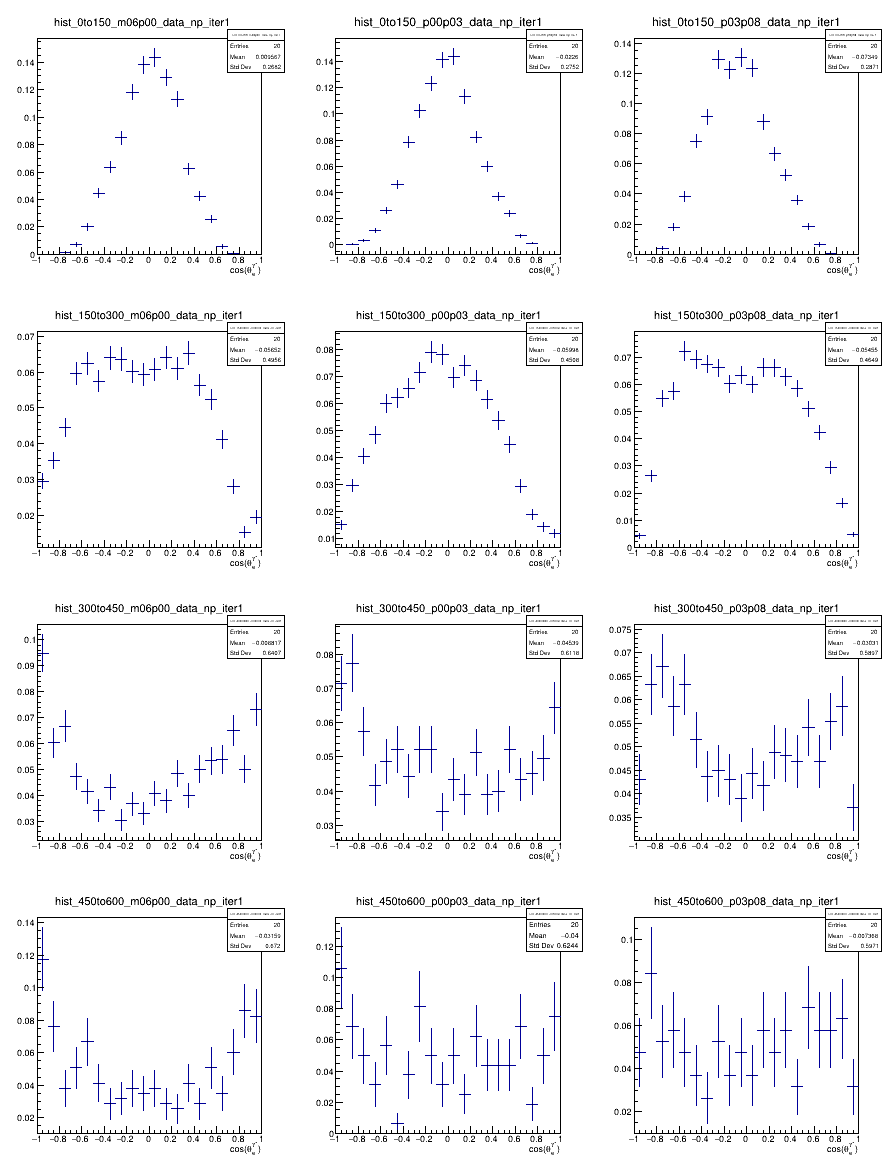

In [6]:
can4 = TCanvas("can4","can4",900,1200)
can4.Divide(3,4)
can4.Draw()
for i, hist in enumerate(histsData_np[0]):
    can4.cd(i+1)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        hist.Draw("COLZ")
    else:
        print(hist)

can4.SaveAs(f'{DIR_NAME}/histsData_np.gif')

In [7]:
import torch

torch.device("mps")
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [8]:
TH1.SetDefaultSumw2

gpytorch.settings.fast_pred_var()
gpytorch.settings.fast_pred_samples()

N_PARAMS = 1

In [9]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[-1, ],
                       [ 1, ]], dtype=torch.float)
bounds = bounds.to(mps_device)


xs = torch.linspace(bounds[0][0], bounds[1][0], 101)

In [10]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
# class GPModel(gpytorch.models.ApproximateGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        mean_x = mean_x.to(mps_device)
        covar_x = covar_x.to(mps_device)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    train_x = train_x.to(mps_device)
    train_y = train_y.to(mps_device)

    # declare the GP
    noise = 1e-1

    likelihood = gpytorch.likelihoods.StudentTLikelihood()
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise
    likelihood = likelihood.to(mps_device)
    model = model.to(mps_device)

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model.cpu(), likelihood.cpu()

In [11]:
# TODO: Come back to standard version
#num_queries = 75
num_queries = 200
num_repeats = 1
num_samples = 20

In [12]:
# -2 is the default value when no feasible has been found
default_value = -1

def fit_bo(HIST_INDEX = 0):
    global bounds

    def objective(xx):
        def generator(xx):
            for x in xx:
                lambda_theta = x

                histsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
                chi2, ndf = calcOneChi2(histsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX])
                allHistsMC.append(histsMC[0][HIST_INDEX])
                if not chi2 or not ndf:
                    return torch.tensor([0])
                yield torch.tensor([1.0/(chi2 / ndf)])
        return torch.stack([a for a in generator(xx)])

    def one_starting_sample():
        result = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(N_PARAMS)
        return result

    feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

    best_fs = []

    print(f"HIST INDEX: {HIST_INDEX}")
    for trial in range(num_repeats):
       # print("trial", trial)

        torch.manual_seed(trial)
       # train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
       # while -2.0*train_x[0][0] - 1.0*train_x[0][2] < -2:
       #     train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
        train_x = torch.stack([one_starting_sample() for _ in range(num_samples)])
        train_utility = objective(train_x).to(mps_device)
        train_x = train_x.to(mps_device)

        for i in tqdm(range(num_queries)):
            feasible_incumbents[trial, i] = train_utility.max()
            before_fit_gp = time()
            utility_model, utility_likelihood = fit_gp_model(
                train_x, train_utility.squeeze(-1)
            )
            after_fit_gp = time()
           # print("Fitting GP took " + str(after_fit_gp - before_fit_gp) + " seconds")
            best_f = train_utility.max()
            best_fs.append(best_f.item())
                
           # policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
           # policy = botorch.acquisition.analytic.LogExpectedImprovement(
            policy = botorch.acquisition.logei.qLogExpectedImprovement(
          # policy = botorch.acquisition.analytic.LogProbabilityOfImprovement(
          # policy = botorch.acquisition.analytic.PosteriorMean(
                model=utility_model,
                best_f=train_utility.max(),
            ).to(mps_device)

            before_optimize_acqf = time()
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                next_x, acq_val = botorch.optim.optimize_acqf(
                    policy,
                    bounds=bounds,
                    #q=5,
                    #num_restarts=5,
                    #raw_samples=400,
                    q=1,
                    num_restarts=40,
                    raw_samples=100,
                )
            after_optimize_acqf = time()
           # print("Optimizing ACQF took " + str(after_optimize_acqf - before_optimize_acqf) + " seconds")

            next_utility = objective(next_x).to(mps_device)

            train_x = torch.cat([train_x, next_x])
            train_utility = torch.cat([train_utility, next_utility])
    torch.save(feasible_incumbents, f"{DIR_NAME}/incumbents_" + str(HIST_INDEX) + ".pth")
    fout = TFile(f"{DIR_NAME}/out_{HIST_INDEX}.root","RECREATE")
    fout.cd()
    for hist in allHistsMC:
       # print ("Writing hist: ", hist.GetName())
        hist.Write()
    for j, hists in enumerate(histsData_np):
        for k, hist in enumerate(hists):
                hist.Write()
               # print ("Writing hist: ", j, k, hist)
    fout.Close()

    with torch.no_grad():
        predictive_distribution = utility_likelihood(utility_model(xs))
        acquisition_score = policy(xs.unsqueeze(1))

    lambda_thetas     = train_x.flatten()
    
    c = torch.stack((
        torch.arange(0,num_queries, dtype=int),
        lambda_thetas[0:num_queries],
        train_utility.squeeze()[0:num_queries],
        (feasible_incumbents==feasible_incumbents.max())[0],
        feasible_incumbents[0]
    ),0).transpose(-2,-1)
    torch.set_printoptions(precision=4,threshold=10_000, linewidth=120)
    sort_index = c[:, N_PARAMS + 1].sort()[1]
    c_sorted = c[sort_index]
    train_x_sorted = train_x[sort_index]

    return c_sorted, train_x_sorted, predictive_distribution

In [13]:
c_sorted_all = []
train_x_sorted_all = []
predictive_mean_all = []
predictive_lower_all = []
predictive_upper_all = []

for HIST_INDEX in range_used:
    allHistsMC = []
    if read_saved:
        c_sorted = torch.load(f"{DIR_NAME}/c_sorted_" + str(HIST_INDEX) + ".pth")
        train_x_sorted = torch.load(f"{DIR_NAME}/train_x_sorted_" + str(HIST_INDEX) + ".pth")
        predictive_distribution = torch.load(f"{DIR_NAME}/predictive_distribution_" + str(HIST_INDEX) + ".pth")

        file = TFile(f"{DIR_NAME}/out_{HIST_INDEX}.root", "read")
        names = [key.GetName() for key in file.GetListOfKeys()]
        names = [name for name in names if "MC" in name]
        for name in names:
            allHistsMC.append(file.Get(name))
    else:
        c_sorted, train_x_sorted, predictive_distribution = fit_bo(HIST_INDEX)
        print(c_sorted[-5:])
        
        torch.save(c_sorted, f"{DIR_NAME}/c_sorted_" + str(HIST_INDEX) + ".pth")
        torch.save(train_x_sorted, f"{DIR_NAME}/train_x_sorted_" + str(HIST_INDEX) + ".pth")
        torch.save(predictive_distribution, f"{DIR_NAME}/predictive_distribution_" + str(HIST_INDEX) + ".pth")

    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()
    print("AFTER_READING: ", predictive_mean[100], predictive_lower[100], predictive_upper[100])

    c_sorted_all.append(c_sorted)
    train_x_sorted_all.append(train_x_sorted)
    predictive_mean_all.append(predictive_mean)
    predictive_lower_all.append(predictive_lower)
    predictive_upper_all.append(predictive_upper)



AFTER_READING:  tensor(0.0476) tensor(-0.0099) tensor(0.1050)
AFTER_READING:  tensor(0.0086) tensor(-0.0487) tensor(0.0660)
AFTER_READING:  tensor(0.0050) tensor(-0.0523) tensor(0.0624)
AFTER_READING:  tensor(0.0042) tensor(-0.0766) tensor(0.0849)
AFTER_READING:  tensor(0.0085) tensor(-0.0716) tensor(0.0886)
AFTER_READING:  tensor(0.0035) tensor(-0.0764) tensor(0.0834)
AFTER_READING:  tensor(0.0088) tensor(-0.0719) tensor(0.0895)
AFTER_READING:  tensor(0.0131) tensor(-0.0674) tensor(0.0935)
AFTER_READING:  tensor(0.0089) tensor(-0.0722) tensor(0.0900)
AFTER_READING:  tensor(0.0332) tensor(-0.0443) tensor(0.1107)
AFTER_READING:  tensor(0.0719) tensor(-0.0066) tensor(0.1505)
AFTER_READING:  tensor(0.0417) tensor(-0.0379) tensor(0.1213)


In [14]:
from ipywidgets import interact, Layout, IntSlider, FloatSlider
import numpy as np

axis_title = r"$cos(\theta_e^{\gamma*})$"

def oneplot(ax, tensor, title):
        
        global xs
        
       # pos = ax.plot(xs, tensor, ymin=0, ymax=tensor.max())
        pos = ax.plot(xs, tensor)
       # ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2]))
        ax.set_title(title)
        ax.set_xlabel(axis_title)

# def f(ax):
#        return oneplot(ax, predictive_mean, r"ndf$/\chi^2$")

gStyle.SetOptStat(0)

can_cmp_ind = 0

def plotComparison(can, pad_nr1, pad_nr2, histMC, histData, hist_index, pull_title):
   # print(f"PLOTTING: {histMC.GetName()} and {histData.GetName()}")
    global can_cmp_ind

    curr_bin = bins[hist_index]
    title = f"{curr_bin.m_min} < #it{{M}}_{{ee}} < {curr_bin.m_max}, {curr_bin.z_min} < cos(#theta^{{CM}}_{{#gamma*}}) < {curr_bin.z_max}"
    
    pad = can.cd(pad_nr1)
    pad.SetRightMargin(0.16)
    histData.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
    histData.SetTitle(title)
    histData.Draw()
    histMC.SetLineColor(2)
    histMC.Draw("SAMEHIST")
    pad = can.cd(pad_nr2)
    pad.SetRightMargin(0.16)
    hdiff = diffHist(histMC, histData)
    hdiff.SetTitle(pull_title)
    hdiff.GetYaxis().SetTitle("Pull value")
    hdiff.Draw("HIST")
    can.Update()
    can.Modified()
    can.Update()
    
    return hdiff

In [15]:
def bin_index(x, min, max):
        return int((x-min)/(max-min)*101)

def covariance_fit_scipy(predictive_mean, predictive_lower, predictive_upper, best, HIST_INDEX, ax):
    def gaus1d(x, A, mean_x, sigma_x):
        x = x - mean_x
        z = A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        return z
    def gaus1d_offset(x, A, mean_x, sigma_x, offset):
        x = x - mean_x
        z = offset + A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        return z

    def fit_1d(ax):
        curr_bin = bins[HIST_INDEX]
        title = f"{curr_bin.m_min} < $M_{{ee}}$ < {curr_bin.m_max}, {curr_bin.z_min} < $cos(\\theta^{{CM}}_{{\gamma*}})$ < {curr_bin.z_max}"
        
        mean_x = best[0].item()

        scale1 = bounds[1][0].item()
        scale2 = bounds[1][0].item()
        proj_min_X = bounds[0][0].item()
        proj_max_X = bounds[1][0].item()

        proj = predictive_mean
        proj_lower = predictive_lower
        proj_upper = predictive_upper

       # xmin_ind = max(0,   bin_index(mean_x, proj_min_X, proj_max_X)-50)
       # xmax_ind = min(100, bin_index(mean_x, proj_min_X, proj_max_X)+50)
        xmin_ind = 0
        xmax_ind = 100
        xmin = proj_min_X + xmin_ind / 101. * (proj_max_X - proj_min_X)
        xmax = proj_min_X + (xmax_ind + 1) / 101. * (proj_max_X - proj_min_X)

        x = np.linspace(-1, 1, 101)

        proj1 = proj[xmin_ind:xmax_ind]
        print("range ", xmin_ind, xmax_ind, xmin, xmax)
    
       # initial_guess = (1.0, mean_x, 0.2*(proj_max_X-proj_min_X))
        initial_guess = (1.0, mean_x, 0.2*(proj_max_X-proj_min_X), 0)
        eps = 0.001
       # param_bounds = ([0,mean_x-eps,0],[np.inf,mean_x+eps,2])
       # if mean_x >= 1.0:
       #     param_bounds = ([0,mean_x-eps,0],[np.inf,2,2])
        param_bounds = ([0,mean_x-eps,0,-np.inf],[np.inf,mean_x+eps,2,np.inf])
        if mean_x >= 1.0:
            param_bounds = ([0,mean_x-eps,0,-np.inf],[np.inf,2,2,np.inf])
        ax.plot(x, proj, label="Estimated values")
        ax.fill_between(x, proj_lower, proj_upper, alpha=0.5)
        ax.plot(x, proj, label="Estimated values")
        ax.set_title(title)
        ax.set_xlabel(r"$\lambda_{\theta}$")
        ax.set_ylabel("ndf$/\chi^2$")
        try:
            popt, pcov = opt.curve_fit(gaus1d_offset, x[xmin_ind:xmax_ind], proj1, p0 = initial_guess, bounds=param_bounds, maxfev=2000)
            fit_result = gaus1d_offset(x, *(popt))
    
            ax.plot(x, fit_result, label="Gaussian fit")
            ax.set_ylim([0,1.5*predictive_upper.max()])
            ax.legend()
        except RuntimeError as e:
            print(f"There was an exception {e}")
            popt, pcov = None, None
        return popt, pcov

   # params0, _ = fit_1d(ax[1][0])
    params0, _ = fit_1d(ax)
    plt.savefig(f"{DIR_NAME}/chi2_best_{HIST_INDEX}.png", bbox_inches="tight")

    try:
        return params0[2]
    except:
        return None

#2 [[<cppyy.gbl.TH1F object at 0x2d0590220>, <cppyy.gbl.TH1F object at 0x2d0590610>, <cppyy.gbl.TH1F object at 0x2d0590a00>, <cppyy.gbl.TH1F object at 0x2d05918a0>, <cppyy.gbl.TH1F object at 0x2d0591c90>, <cppyy.gbl.TH1F object at 0x2d0592080>, <cppyy.gbl.TH1F object at 0x2d0592470>, <cppyy.gbl.TH1F object at 0x2d0592860>, <cppyy.gbl.TH1F object at 0x2d0592c50>, <cppyy.gbl.TH1F object at 0x2d0593040>, <cppyy.gbl.TH1F object at 0x2d0593430>, <cppyy.gbl.TH1F object at 0x2d0593820>], [<cppyy.gbl.TH1F object at 0x1577c7240>, <cppyy.gbl.TH1F object at 0x1577c7a20>], [<cppyy.gbl.TH1F object at 0x1577c7630>, <cppyy.gbl.TH1F object at 0x1577c7e10>]]
#2 [[<cppyy.gbl.TH1F object at 0x2d05963f0>, <cppyy.gbl.TH1F object at 0x2d0597b20>, <cppyy.gbl.TH1F object at 0x2d0597f10>, <cppyy.gbl.TH1F object at 0x2d0598300>, <cppyy.gbl.TH1F object at 0x2d05986f0>, <cppyy.gbl.TH1F object at 0x2d0598ae0>, <cppyy.gbl.TH1F object at 0x2d0598ed0>, <cppyy.gbl.TH1F object at 0x2d05992c0>, <cppyy.gbl.TH1F object at

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_0.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_1.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_3.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_4.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_6.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_7.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_8.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comp

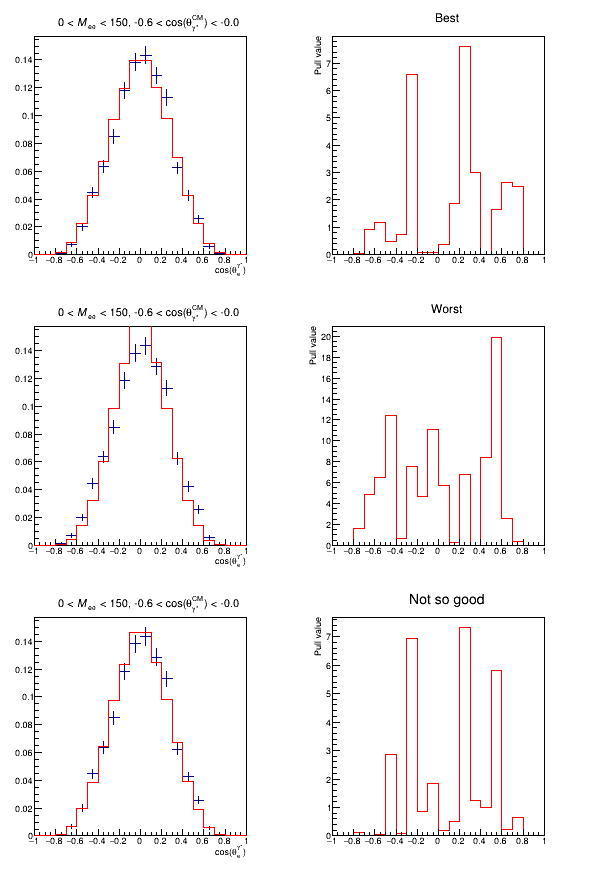

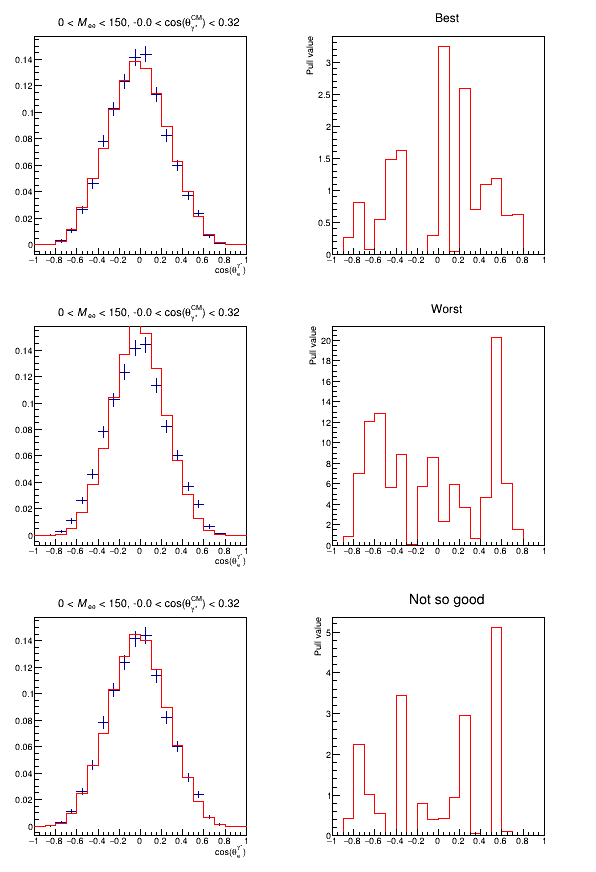

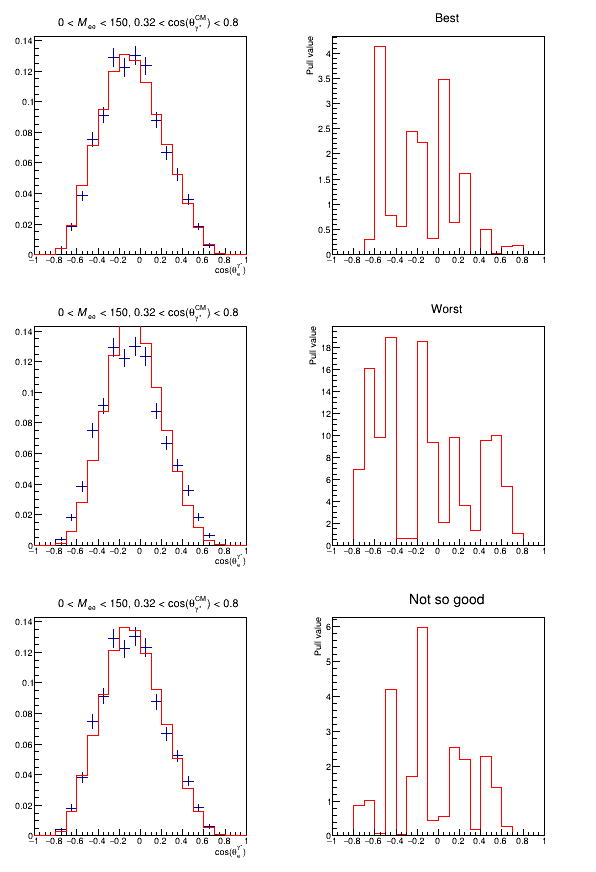

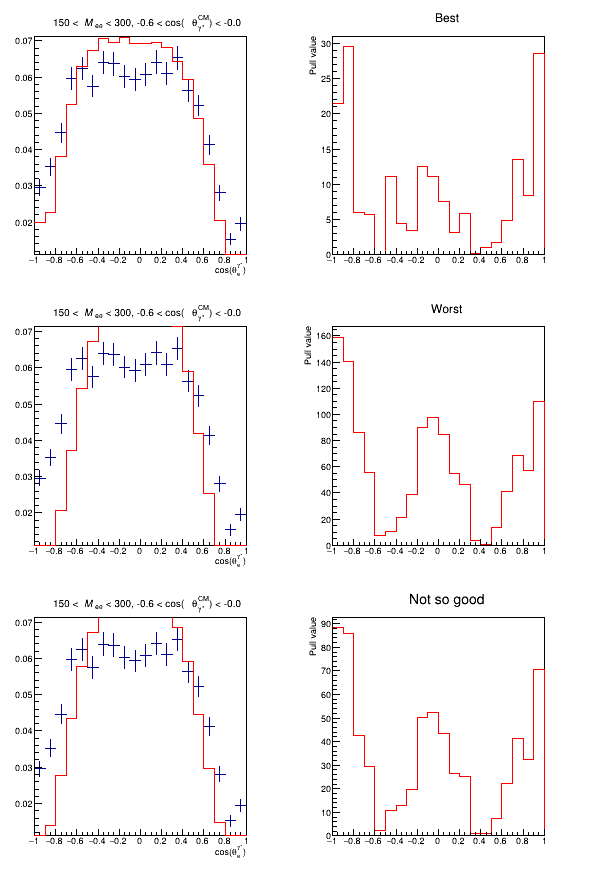

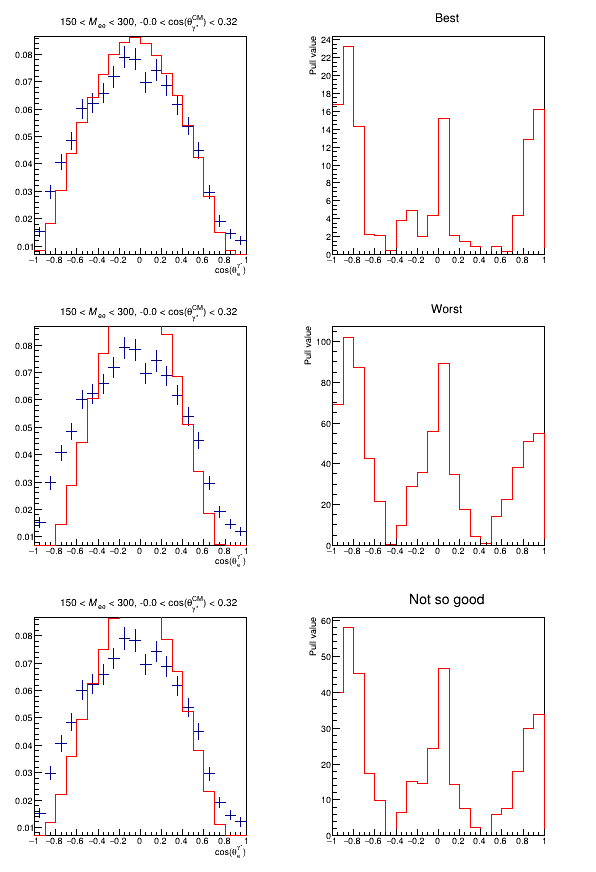

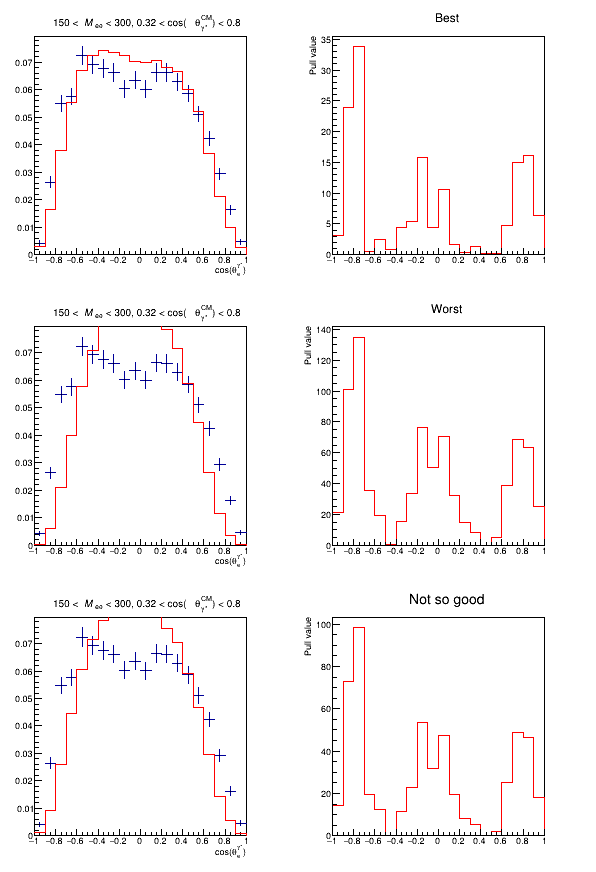

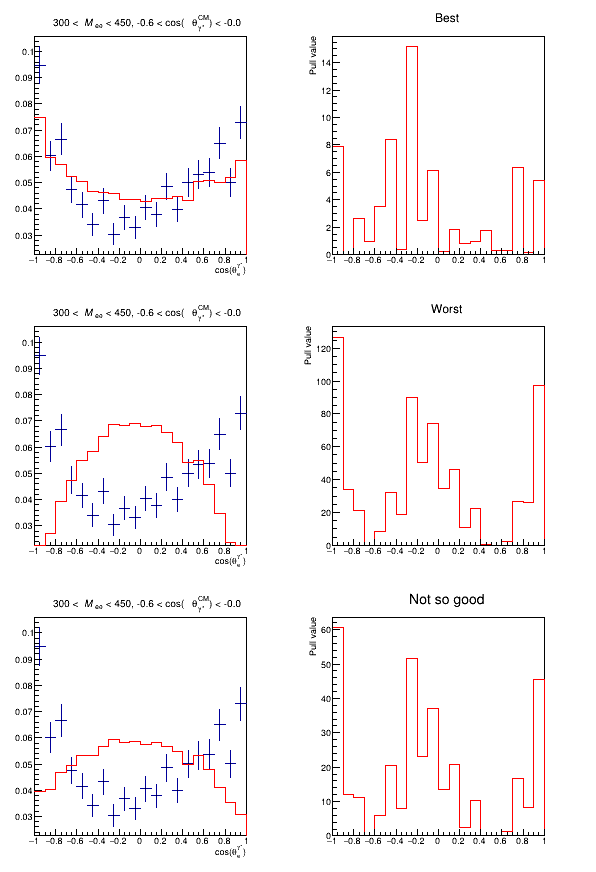

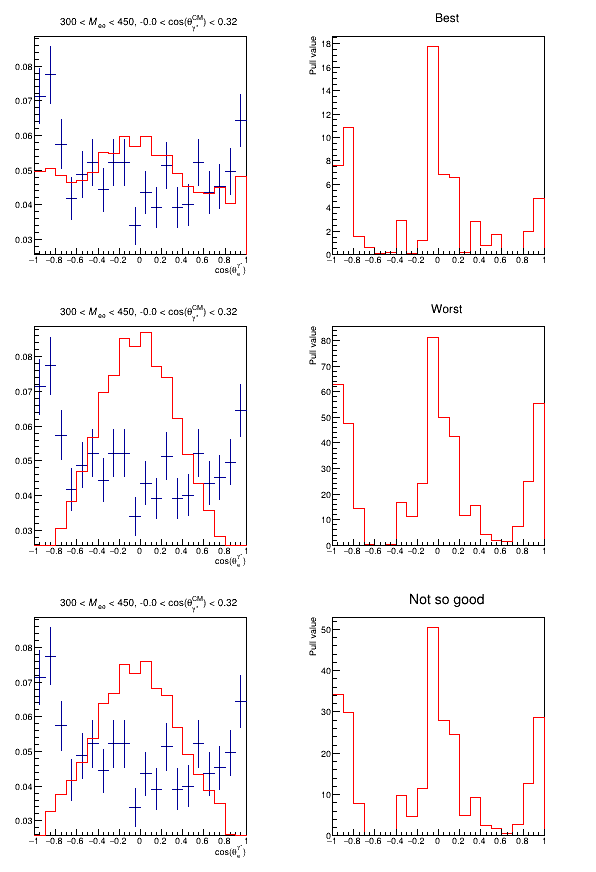

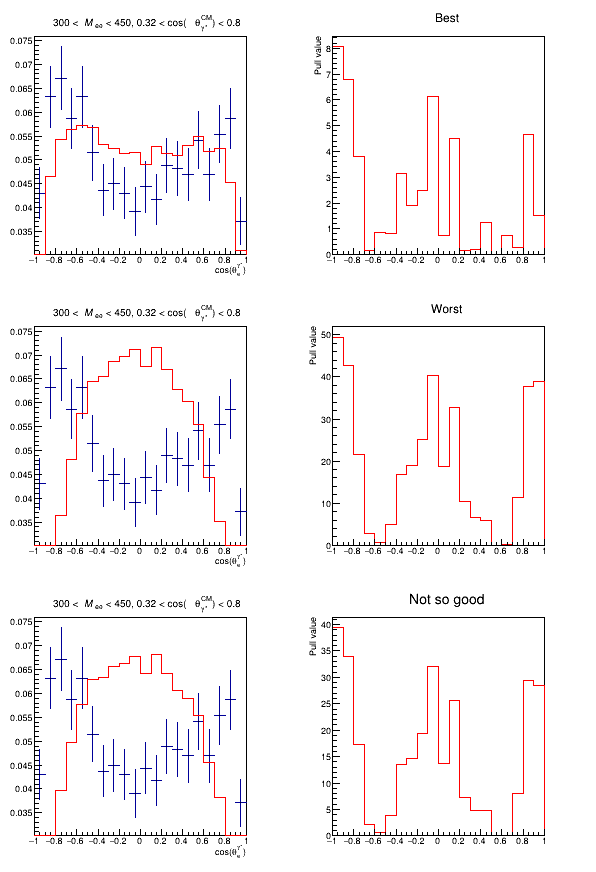

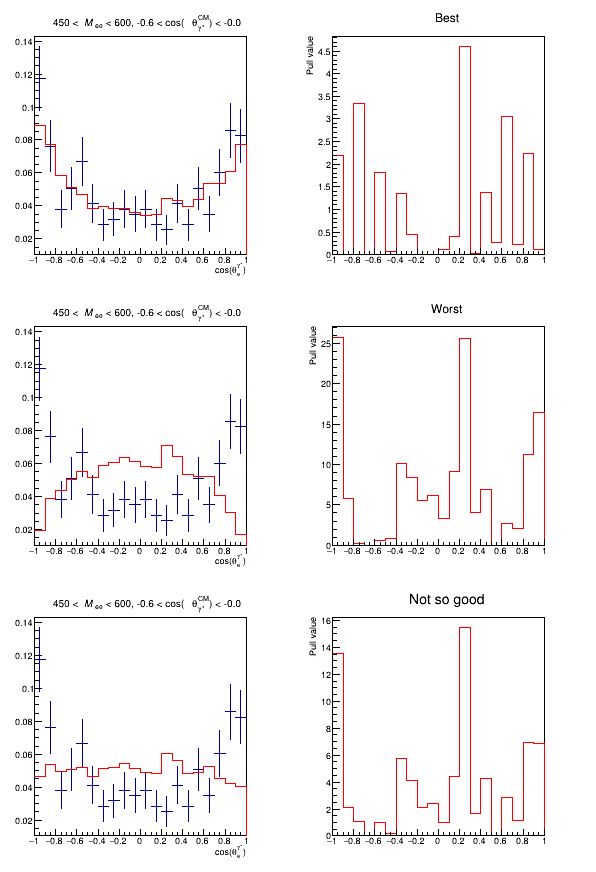

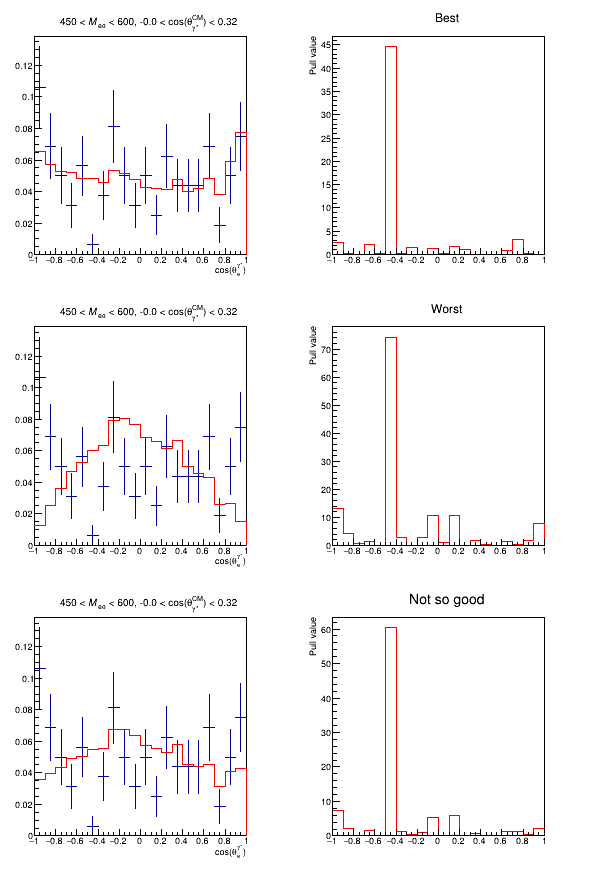

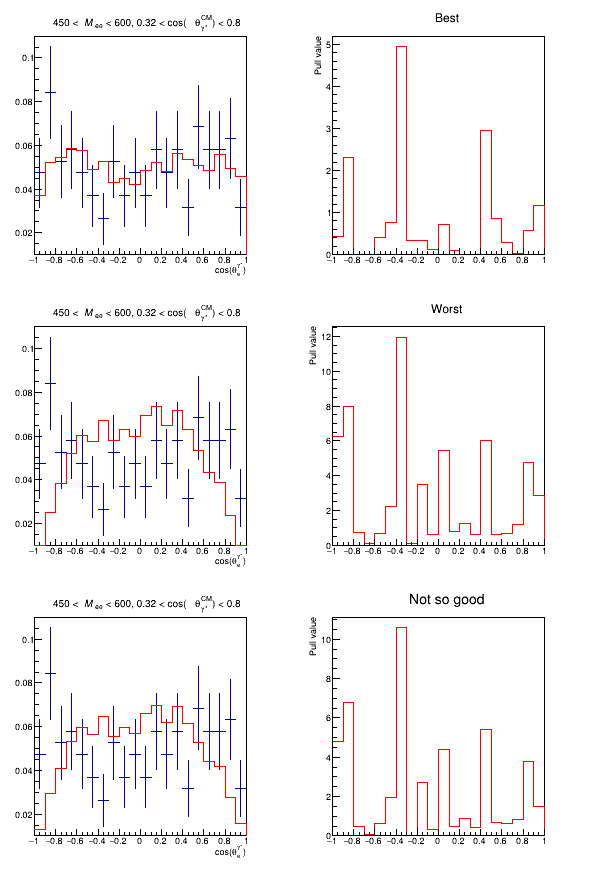

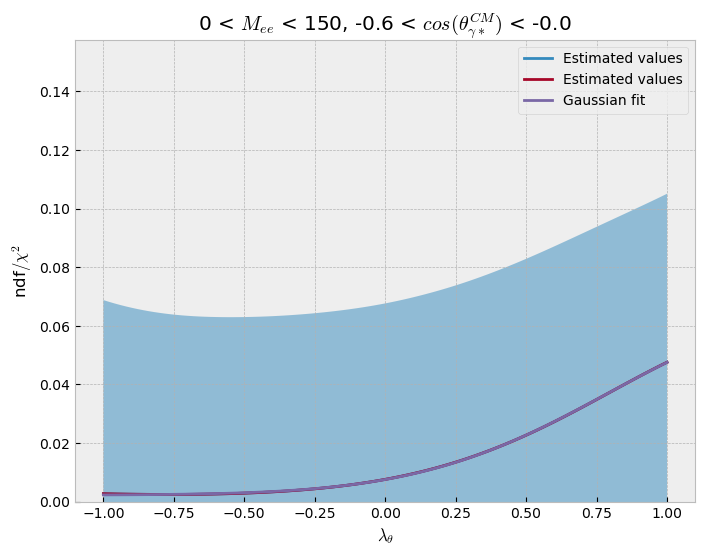

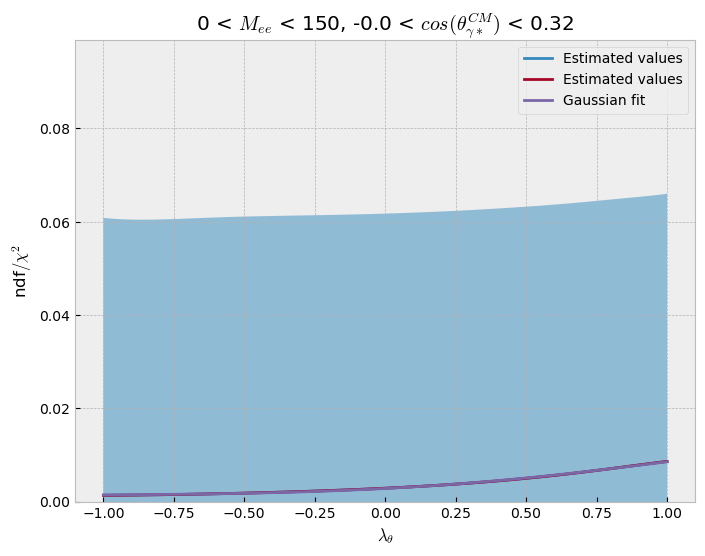

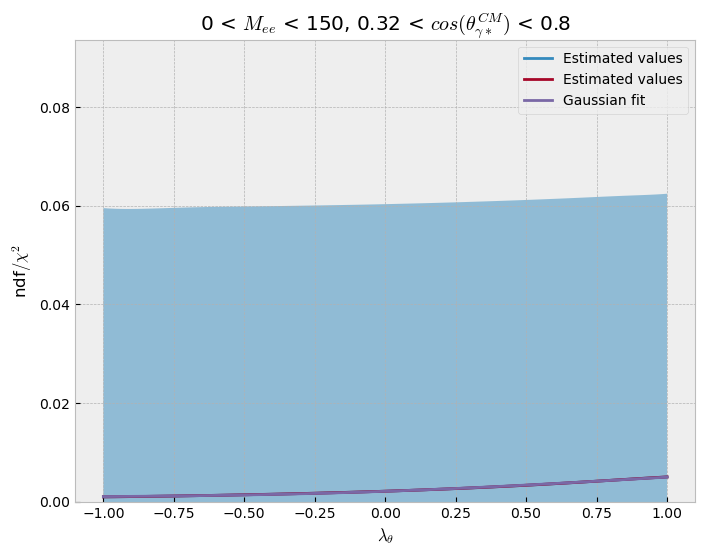

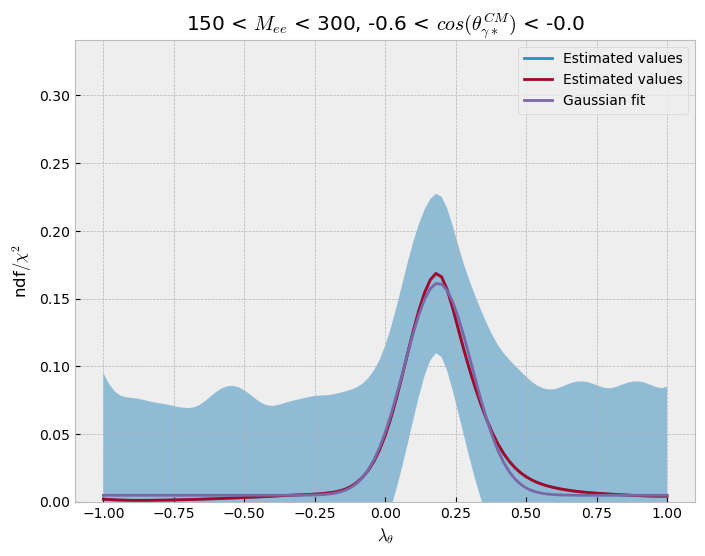

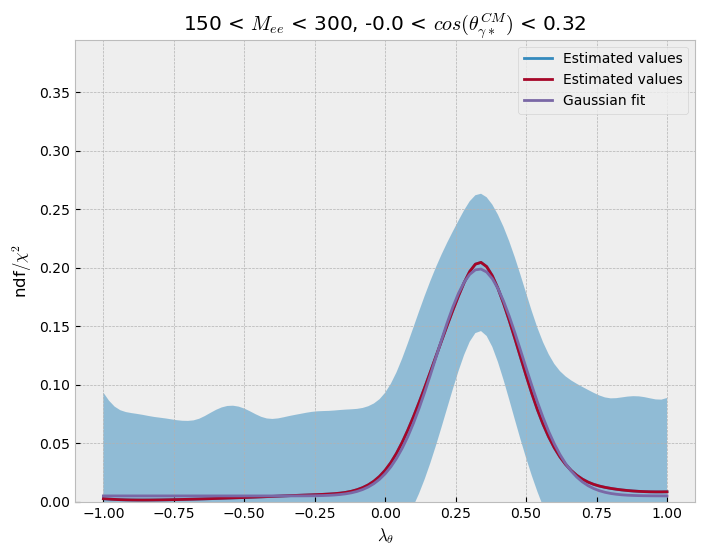

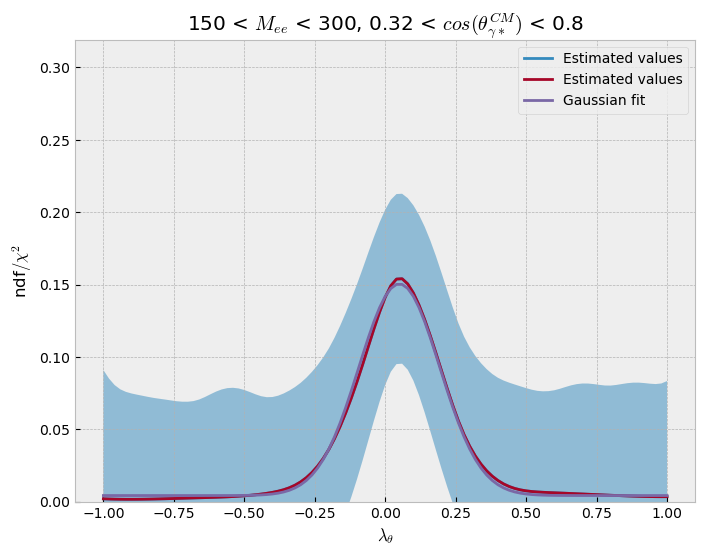

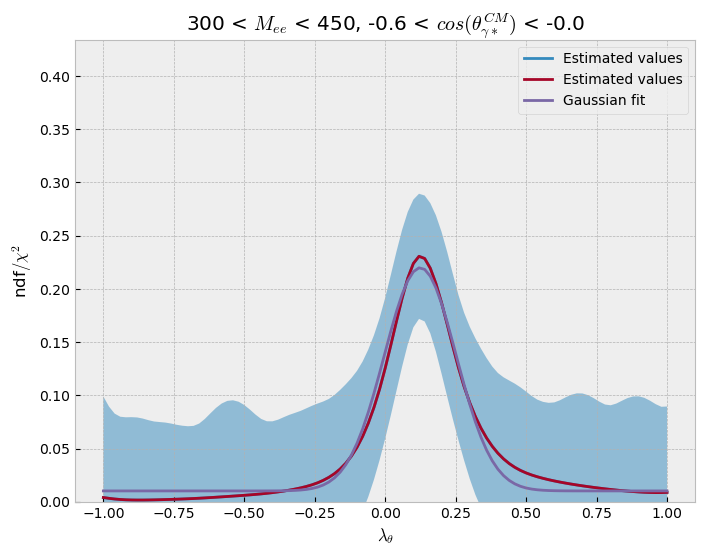

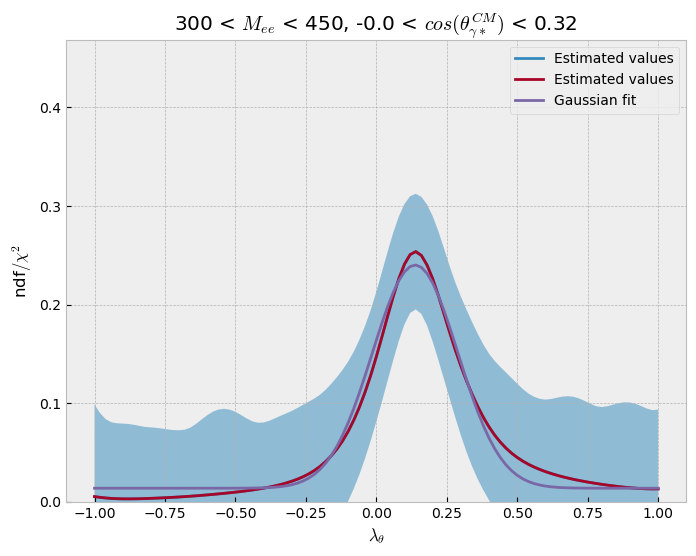

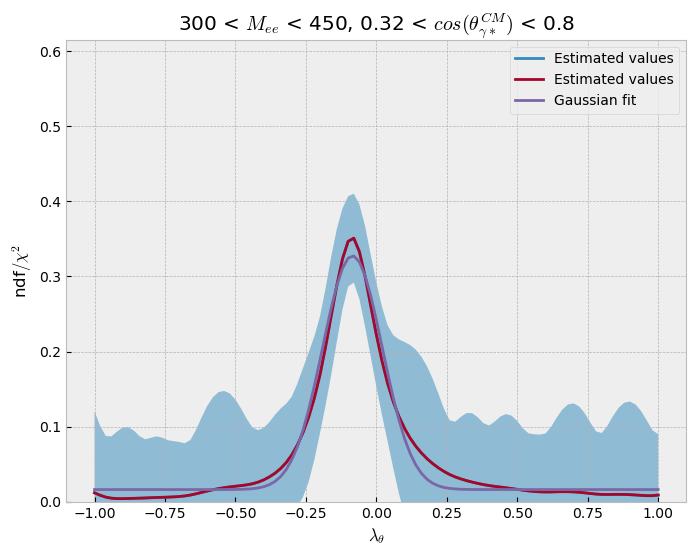

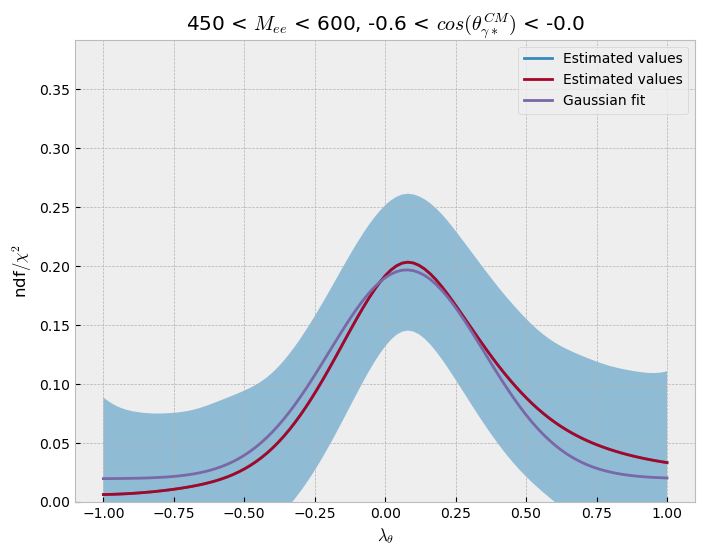

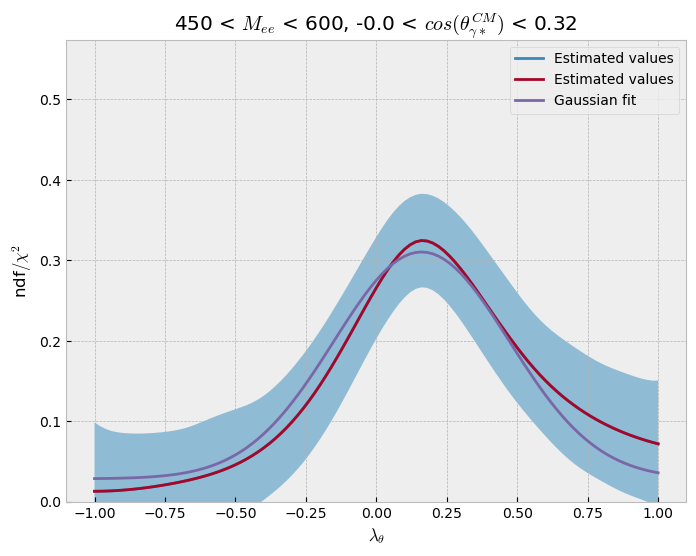

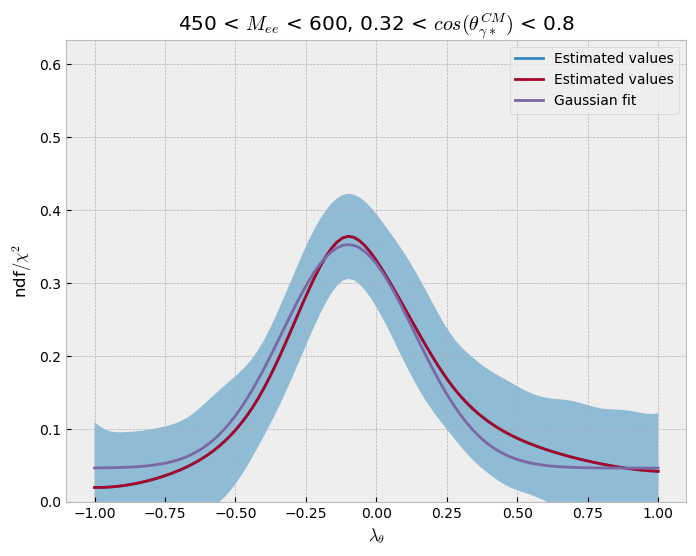

In [16]:

with open(f'{DIR_NAME}/results.txt', 'w') as fout:
    canvases = []
    hdiffs = []
    hmodels = []
    
    for HIST_INDEX in range_used:

        c_sorted = c_sorted_all[HIST_INDEX - range_used.start]
        train_x_sorted = train_x_sorted_all[HIST_INDEX - range_used.start]
        predictive_mean = predictive_mean_all[HIST_INDEX - range_used.start]
        predictive_lower = predictive_lower_all[HIST_INDEX - range_used.start]
        predictive_upper = predictive_upper_all[HIST_INDEX - range_used.start]
        predictive_mean_2 = predictive_mean - predictive_mean.min()

       # ax = plt.axes()
        fig, ax = plt.subplots(nrows=1, ncols=1)
        lambda_theta = train_x_sorted[-1]
        bestHistsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
        hmodels.append(bestHistsMC[0][HIST_INDEX])
        
        can1 = TCanvas(f"can_cmp_{HIST_INDEX}","can",600,900)
        can1.Divide(2,3)
        can1.Draw()        
        canvases.append(can1)
        
        hdiff1 = plotComparison(can1, 1, 2, bestHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Best")
        hdiffs.append(hdiff1)
        
        lambda_theta = train_x_sorted[0]
        worstHistsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
        hmodels.append(worstHistsMC[0][HIST_INDEX])
        hdiff2 = plotComparison(can1, 3, 4, worstHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Worst")
        hdiffs.append(hdiff2)

        shift = 0.75
        if train_x_sorted[-1] > shift - 1:
            diffToBest = torch.tensor([-shift])
        else:
            diffToBest = torch.tensor([+shift])
        lambda_theta = train_x_sorted[-1] + diffToBest
        notSoGoodHistsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
        hmodels.append(notSoGoodHistsMC[0][HIST_INDEX])
        hdiff22 = plotComparison(can1, 5, 6, notSoGoodHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Not so good")
        hdiffs.append(hdiff22)

        can1.SaveAs(f"{DIR_NAME}/comparison_{HIST_INDEX}.gif")

        print(str(HIST_INDEX) + ": Final result:")
        print(str(HIST_INDEX) + ": Final result:", file=fout)
        print(str(HIST_INDEX) + ": lambda_theta = ", c_sorted[-1][1].item())
        print(str(HIST_INDEX) + ": lambda_theta = ", c_sorted[-1][1].item(), file=fout)

        drphiz = covariance_fit_scipy(predictive_mean,predictive_lower,predictive_upper,train_x_sorted[-1],HIST_INDEX,ax)

        try:
            print(str(HIST_INDEX) + ": errors = ", drphiz)
            print(str(HIST_INDEX) + ": errors = ", drphiz, file=fout)
        except:
            print(str(HIST_INDEX) + ": errors could not be determined")
            print(str(HIST_INDEX) + ": errors could not be determined", file=fout)

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_0.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_1.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_3.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_4.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_6.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_7.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_8.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comp

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_0.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_1.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_3.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_4.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_6.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_7.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_8.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comp

#2 [[<cppyy.gbl.TH1F object at 0x2d5c260c0>, <cppyy.gbl.TH1F object at 0x2d5c27210>, <cppyy.gbl.TH1F object at 0x2d5c27600>, <cppyy.gbl.TH1F object at 0x2d5c279f0>, <cppyy.gbl.TH1F object at 0x2d5c27de0>, <cppyy.gbl.TH1F object at 0x2d5c281d0>, <cppyy.gbl.TH1F object at 0x2d5c285c0>, <cppyy.gbl.TH1F object at 0x2d5c289b0>, <cppyy.gbl.TH1F object at 0x2d5c28da0>, <cppyy.gbl.TH1F object at 0x2d5c29190>, <cppyy.gbl.TH1F object at 0x2d5c29580>, <cppyy.gbl.TH1F object at 0x2d5c29970>], [<cppyy.gbl.TH1F object at 0x1564e89a0>, <cppyy.gbl.TH1F object at 0x1564e9180>], [<cppyy.gbl.TH1F object at 0x1564e8d90>, <cppyy.gbl.TH1F object at 0x1564e9570>]]
#2 [[<cppyy.gbl.TH1F object at 0x10bb0e400>, <cppyy.gbl.TH1F object at 0x10bb0e7f0>, <cppyy.gbl.TH1F object at 0x10bb0ebe0>, <cppyy.gbl.TH1F object at 0x10bb0efd0>, <cppyy.gbl.TH1F object at 0x10bb0f3c0>, <cppyy.gbl.TH1F object at 0x10bb0f7b0>, <cppyy.gbl.TH1F object at 0x10bb0fba0>, <cppyy.gbl.TH1F object at 0x10bb0ff90>, <cppyy.gbl.TH1F object at

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc


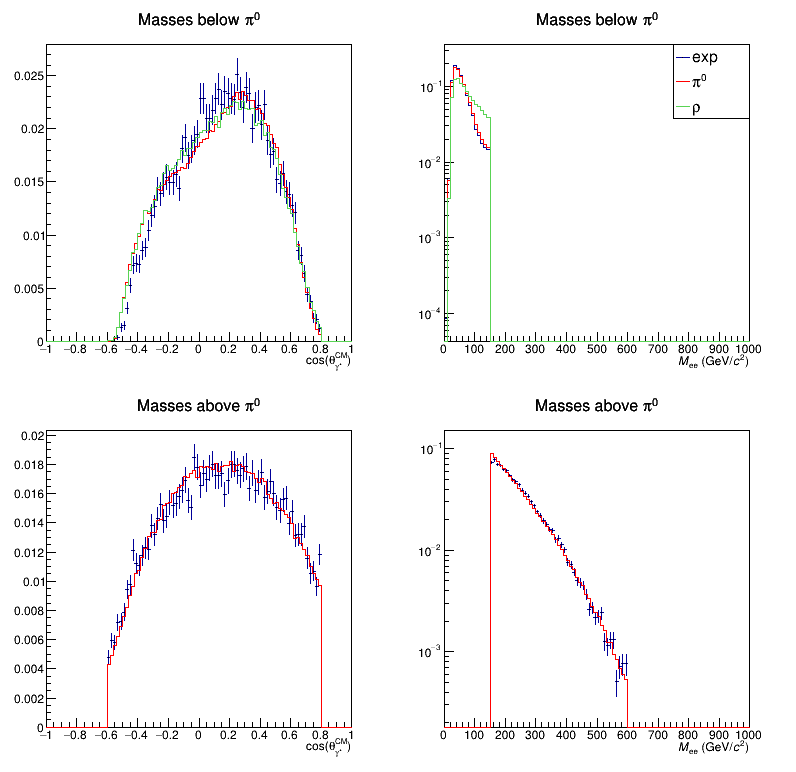

In [20]:
hmodelLowM_rho = histMakerMC_rho.makeHists((1.0))
hmodelLowM_rho[2][0].SetLineColor(8)
hmodelLowM_rho[1][0].SetLineColor(8)

hmodelLowM = histMakerMC_pi0.makeHists((1.0))

fraction = 0.25

hmodelLowM[2][0].Scale(1.0/hmodelLowM[2][0].Integral())
hmodelLowM[1][0].Scale(1.0/hmodelLowM[1][0].Integral())
hmodelLowM_rho[2][0].Scale(1.0/hmodelLowM_rho[2][0].Integral())
hmodelLowM_rho[1][0].Scale(1.0/hmodelLowM_rho[1][0].Integral())

hmodelLowM[2][0].Add(hmodelLowM_rho[2][0], fraction)
hmodelLowM[1][0].Add(hmodelLowM_rho[1][0], fraction)

hmodelLowM[2][0].SetLineColor(2)
hmodelLowM[1][0].SetLineColor(2)
hmodelHigM = getHistMakerMC(3).makeHists(1.0)
hmodelHigM[2][1].SetLineColor(2)
hmodelHigM[1][1].SetLineColor(2)

cc = TCanvas("cc","cc",800,800)
cc.Divide(2,2)
cc.Draw()

cc.cd(1)
dataScale = 1./histsData_np[2][0].Integral()
histsData_np[2][0].Scale(dataScale)
histsData_pp[2][0].Scale(dataScale)
histsData_nn[2][0].Scale(dataScale)
hmodelLowM[2][0].Scale(1./hmodelLowM[2][0].Integral())
hmodelLowM_rho[2][0].Scale(1./hmodelLowM_rho[2][0].Integral())
histsData_np[2][0].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][0].SetTitle("Masses below #pi^{0}")
histsData_np[2][0].Draw()
#histsData_pp[2][0].Draw("SAME")
#histsData_nn[2][0].Draw("SAME")
hmodelLowM[2][0].Draw("SAMEHIST")
hmodelLowM_rho[2][0].Draw("SAMEHIST")

pad = cc.cd(2)
pad.SetLogy()
histsData_np[1][0].Scale(1./histsData_np[1][0].Integral())
hmodelLowM[1][0].Scale(1./hmodelLowM[1][0].Integral())
hmodelLowM_rho[1][0].Scale(1./hmodelLowM_rho[1][0].Integral())
histsData_np[1][0].SetTitle("Masses below #pi^{0}")
histsData_np[1][0].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")
histsData_np[1][0].Draw("HIST")
hmodelLowM[1][0].Draw("SAMEHIST")
hmodelLowM_rho[1][0].Draw("SAMEHIST")

legend = TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(histsData_np[1][0], "exp", "pl")
legend.AddEntry(hmodelLowM[1][0], "#pi^{0}", "l")
legend.AddEntry(hmodelLowM_rho[1][0], "#rho", "l")
legend.Draw()

cc.cd(3)
histsData_np[2][1].Scale(1./histsData_np[2][1].Integral())
hmodelHigM[2][1].Scale(1./hmodelHigM[2][1].Integral())
hmodelLowM_rho[2][1].Scale(1./hmodelLowM_rho[2][1].Integral())
histsData_np[2][1].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][1].SetTitle("Masses above #pi^{0}")
histsData_np[2][1].Draw()
hmodelHigM[2][1].Draw("SAMEHIST")
hmodelLowM_rho[2][1].Draw("SAMEHIST")

pad = cc.cd(4)
pad.SetLogy()
histsData_np[1][1].Scale(1./histsData_np[1][1].Integral())
hmodelHigM[1][1].Scale(1./hmodelHigM[1][1].Integral())
hmodelLowM_rho[1][1].Scale(1./hmodelLowM_rho[1][1].Integral())
histsData_np[1][1].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")
histsData_np[1][1].SetTitle("Masses above #pi^{0}")
histsData_np[1][1].Draw()
hmodelHigM[1][1].Draw("SAMEHIST")
hmodelLowM_rho[1][1].Draw("SAMEHIST")
